In [1]:
import h5py
import scipy.io as io
import PIL as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
import cv2
#from image import *

C:\Users\oriol\AppData\Local\Temp\ipykernel_17692\2821925211.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
def gaussian_filter_density(gt):
    #Generates a density map using Gaussian filter transformation
    
    density = np.zeros(gt.shape, dtype=np.float32)
    
    gt_count = np.count_nonzero(gt)
    
    if gt_count == 0:
        return density

    # FInd out the K nearest neighbours using a KDTree
    
    pts = np.array(list(zip(np.nonzero(gt)[1].ravel(), np.nonzero(gt)[0].ravel())))
    leafsize = 2048
    
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    
    # query kdtree
    distances, locations = tree.query(pts, k=4)

        
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        
        #Convolve with the gaussian filter
        
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    
    return density

In [3]:
root = r'C:\Users\oriol\ShanghaiTec'

In [4]:
'''
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train,part_A_test,part_B_train,part_B_test]
'''
part_A_train = os.path.join(root,'part_A_final\\train_data','images')
part_A_test = os.path.join(root,'part_A_final\\test_data','images')
part_B_train = os.path.join(root,'part_B_final\\train_data','images')
part_B_test = os.path.join(root,'part_B_final\\test_data','images')
path_sets = [part_A_train,part_A_test,part_B_train,part_B_test]

In [5]:
# List of all image paths

img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
print(len(img_paths))

1016


In [6]:
# reducimos para el test el numeor de imagenes
img_paths = img_paths[0:10]

In [7]:
#Hacemos que las imagenes sean multiplo de 16, ajustando su tamaño
def fix_singular_shape(img, unit_len=16):
    """
    Some network like w-net has both N maxpooling layers and concatenate layers,
    so if no fix for their shape as integeral times of 2 ** N, the shape will go into conflict.
    """
    hei_dst, wid_dst = img.shape[0] + ((unit_len - img.shape[0] % unit_len)%unit_len), img.shape[1] + ((unit_len - img.shape[1] % unit_len)%unit_len)
    if len(img.shape) == 3:
        img = cv2.resize(img, (wid_dst, hei_dst), interpolation=cv2.INTER_LANCZOS4)
    elif len(img.shape) == 2:
        GT = int(round(np.sum(img)))
        img = cv2.resize(img, (wid_dst, hei_dst), interpolation=cv2.INTER_LANCZOS4)
        img = img / (np.sum(img) / GT)
    return img

In [8]:

from tqdm import tqdm

i = 0
for img_path in tqdm(img_paths):
        
    
    # Load sparse matrix
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    
    #Read image
    img= cv2.imread(img_path)
    ########################################################## resize multiplo sw 18
    #img = fix_singular_shape(img, unit_len=16)
    ###################################################
    #cv2.imwrite(img_path, img)
    
    # Create a zero matrix of image size
    k = np.zeros((img.shape[0],img.shape[1]))
    
    gt = mat["image_info"][0,0][0,0][0]
    
    #Generate hot encoded matrix of sparse matrix
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    
    # generate density map
    k = gaussian_filter_density(k)
    ########################################################## resize multiplo sw 816
    k = fix_singular_shape(k, unit_len=16)
    ###################################################
    
    # File path to save density map
    file_path = img_path.replace('.jpg','.h5').replace('images','ground_truth')
    
    
    with h5py.File(file_path, 'w') as hf:
            hf['density'] = k
    


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\oriol\AppData\Local\Temp\ipykernel_17692\523822739.py:33: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
100%|██████████| 10/10 [02:04<00:00, 12.48s/it]


In [12]:
file_path = img_paths[2].replace('.jpg','.h5').replace('images','ground_truth') 
print(file_path)

C:\Users\oriol\ShanghaiTec\part_A_final\train_data\ground_truth\IMG_100.h5


Sum =  369.99994


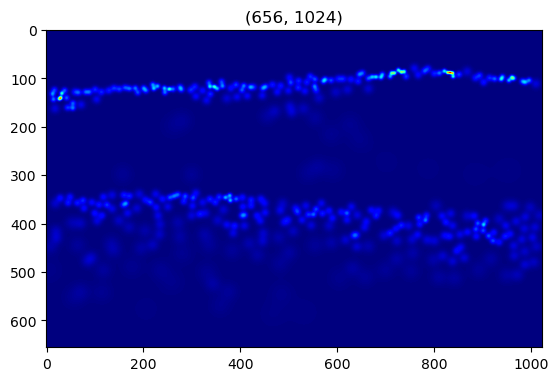

In [14]:
#Sample Ground Truth
gt_file = h5py.File(file_path,'r')
groundtruth = np.asarray(gt_file['density'])
plt.title(groundtruth.shape)
plt.imshow(groundtruth,cmap=CM.jet)
print("Sum = " ,np.sum(groundtruth))

C:\Users\oriol\ShanghaiTec\part_A_final\train_data\images\IMG_100.jpg


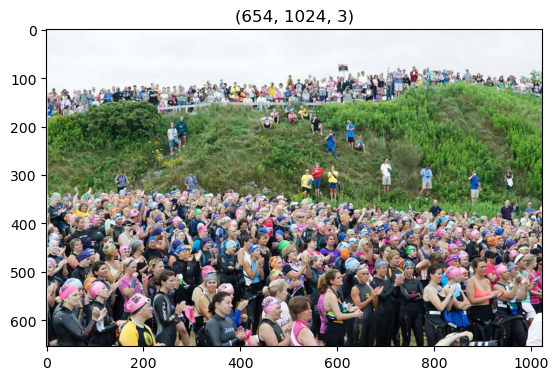

In [15]:
# Image corresponding to the ground truth
img = plt.imread(file_path.replace('.h5','.jpg').replace('ground_truth','images'))
plt.title(img.shape)
plt.imshow(img)
print(file_path.replace('.h5','.jpg').replace('ground_truth','images'))